In [ ]:
!pip install comet_ml --quiet
import comet_ml
COMET_API_KEY = "kqkAg2jvqkbZ0xIbry7OhDyem"

# Import Tensorflow 2.0
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0
assert COMET_API_KEY != "", "Please insert your Comet API Key"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.4/677.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:

path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')

loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1263889489/1263889489 [==============================] - 14s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [ ]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

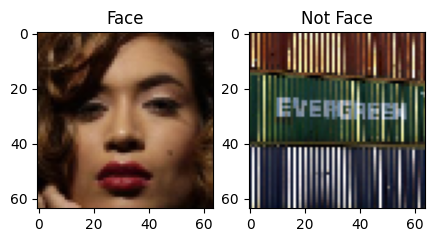

In [ ]:
### Examining the CelebA training dataset ###

#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 23 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 39 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

In [ ]:
### Define the CNN model ###

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

In [ ]:
### Create a Comet experiment to track our training run ###
def create_experiment(project_name, params):
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name=project_name)
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment


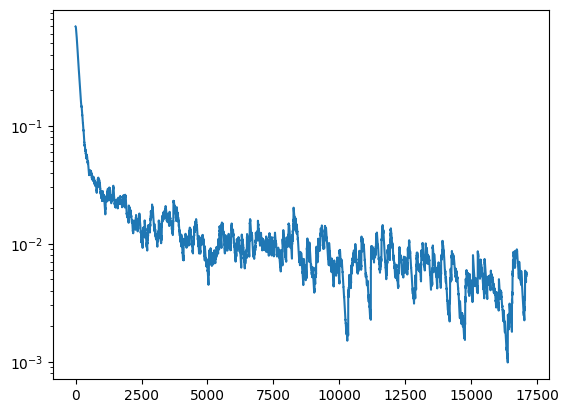

100%|██████████| 3434/3434 [00:42<00:00, 80.37it/s]


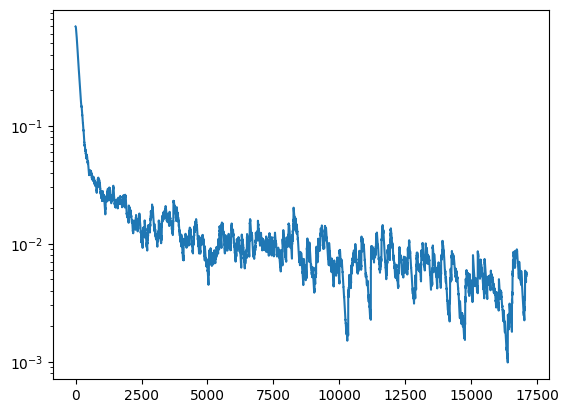

In [ ]:
### Train the standard CNN ###

# Training hyperparameters
params = dict(
  batch_size = 32,
  num_epochs = 5,  # keep small to run faster
  learning_rate = 5e-4,
)

experiment = create_experiment("6S191_Lab2_Part2_CNN", params)

optimizer = tf.keras.optimizers.Adam(params["learning_rate"]) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y, logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
  for idx in tqdm(range(loader.get_train_size()//params["batch_size"])):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(params["batch_size"])
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

    experiment.log_metric("loss", loss.numpy().mean(), step=step)
    step += 1

In [ ]:
### Evaluation of standard CNN ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 1s 4ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9984


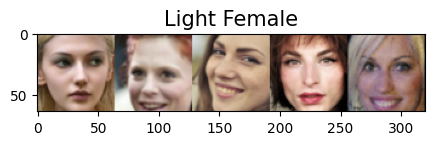

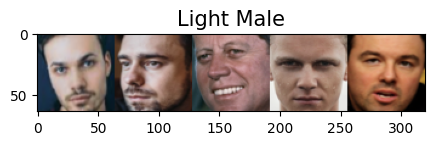

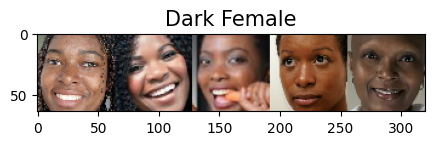

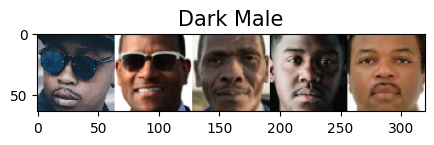

In [ ]:
### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys):
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

In [ ]:
### Defining the VAE loss function ###

''' Function to calculate VAE loss given:
      an input x,
      reconstructed output x_recon,
      encoded means mu,
      encoded log of standard deviation logsigma,
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5 * tf.reduce_sum(tf.square(mu) + tf.exp(logsigma) - logsigma - 1, axis=-1)


  reconstruction_loss = tf.reduce_mean(tf.square(x-x_recon))

  vae_loss = kl_weight*latent_loss + reconstruction_loss

  return vae_loss

In [ ]:
### VAE Reparameterization ###

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  z = z_mean + epsilon*z_logsigma
  return z

In [ ]:
### Loss function for DB-VAE ###

"""Loss function for DB-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: DB-VAE total loss
    classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  vae_loss = vae_loss_function(x, x_pred, mu, logsigma) # TODO

  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(y,y_logit)

  #   indicator that reflects which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # samples
  total_loss = tf.reduce_mean(face_indicator*vae_loss) + tf.reduce_mean(classification_loss)

  return total_loss, classification_loss

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  decoder = tf.keras.Sequential([
    Dense(units=4*4*6*n_filters),
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [ ]:

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    # TODO: call the sampling function defined above
    z = sampling(z_mean,z_logsigma)
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    reconstruction = self.decoder(z)# TODO
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x):
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    z = self.reparameterize(z_mean,z_logsigma)# TODO


    recon = self.decode(z)# TODO

    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

In [ ]:

def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [ ]:
### Resampling algorithm for DB-VAE ###

'''Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data'''
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Recomputing the sampling probabilities")

    mu = get_latent_mu(images, dbvae)

    # Initialize sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])

    # Consider the distribution for each latent variable
    for i in range(mu.shape[1]):  # assuming mu.shape[1] is latent_dim
        latent_distribution = mu[:, i]

        # Generate a histogram of the latent distribution
        hist_density, bin_edges = np.histogram(latent_distribution, density=True, bins=bins)

        # Adjust bin edges to ensure all values are included
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')

        bin_idx = np.digitize(latent_distribution, bin_edges)

        # Smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # Invert the density function to get probabilities
        p = 1.0 / hist_smoothed_density[bin_idx - 1]

        # Normalize probabilities
        p = p / np.sum(p)

        # Update sampling probabilities
        training_sample_p = np.maximum(training_sample_p, p)

    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p


Starting epoch 5/5
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

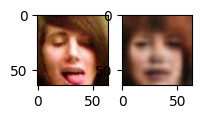

 14%|█▍        | 494/3434 [00:06<00:34, 85.81it/s]

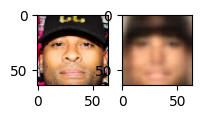

 29%|██▉       | 994/3434 [00:12<00:27, 88.88it/s]

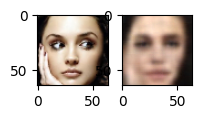

 44%|████▎     | 1495/3434 [00:18<00:21, 88.18it/s]

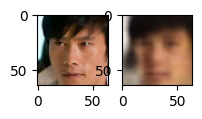

 58%|█████▊    | 1995/3434 [00:25<00:15, 92.80it/s]

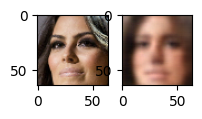

 73%|███████▎  | 2500/3434 [00:31<00:09, 94.20it/s]

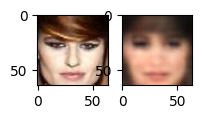

 87%|████████▋ | 2993/3434 [00:38<00:04, 92.36it/s]

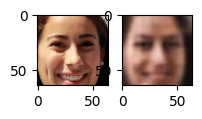

100%|██████████| 3434/3434 [00:43<00:00, 79.11it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : helpless_slate_1919
COMET INFO:     url                   : https://www.comet.com/johnnyhuang101/6s191-lab2-part2-dbvae/0ff9bf8bd215428ab829e237c6064a63
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [17170] : (0.006104036699980497, 0.8661367893218994)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.9

In [ ]:

params = dict(
  batch_size = 32,
  learning_rate = 5e-4,
  latent_dim = 100,
  num_epochs = 5, #DB-VAE needs slightly more epochs to train
)

experiment = create_experiment("6S191_Lab2_Part2_DBVAE", params)

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(params["latent_dim"])
optimizer = tf.keras.optimizers.Adam(params["learning_rate"])

@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    loss, class_loss = debiasing_loss_function(x,x_recon,y,y_logit,z_mean,z_logsigma) # TODO

  grads = tape.gradient(loss,dbvae.trainable_variables) # TODO

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
step = 0
for i in range(params["num_epochs"]):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, params["num_epochs"]))

  p_faces = get_training_sample_probabilities(all_faces,dbvae) # TODO

  for j in tqdm(range(loader.get_train_size() // params["batch_size"])):
    # load a batch of data
    (x, y) = loader.get_batch(params["batch_size"], p_pos=p_faces)

    # loss optimization
    loss = debiasing_train_step(x, y)
    experiment.log_metric("loss", loss.numpy().mean(), step=step)

    # plot the progress every 200 steps
    if j % 500 == 0:
      mdl.util.plot_sample(x, y, dbvae)

    step += 1

experiment.end()

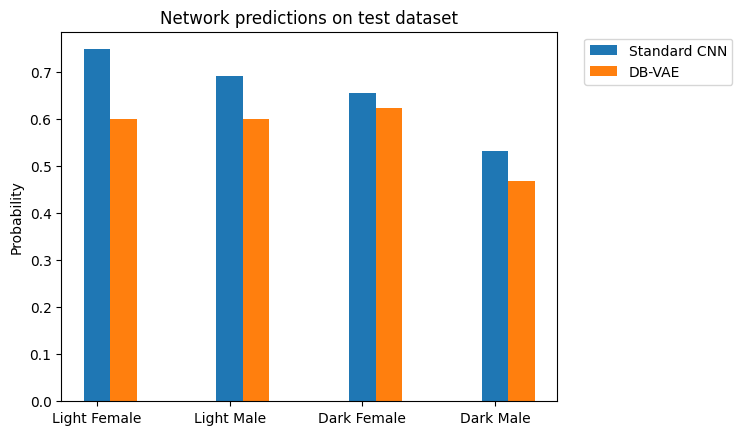

In [ ]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys);
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");
